In [0]:
from unittest import mock
import os
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from tensorflow.python.estimator import estimator
from tensorflow.python.training.basic_session_run_hooks import CheckpointSaverHook, meta_graph
from tensorflow.python.platform import tf_logging as logging
from google.colab import drive, auth

In [0]:
#################################### SETUP #####################################

def setup():
    drive.mount('/content/gdrive')
    auth.authenticate_user()


def upload_credentials():
    # Upload credentials to TPU.
    with tf.Session(TF_MASTER) as sess:    
        with open('/content/adc.json', 'r') as f:
            auth_info = json.load(f)
        tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)

In [0]:
################################# DATA INPUT ###################################

def parser(serialized_example):
        """Parses a single example into image and label tensors."""
        features = tf.parse_single_example(
            serialized_example,
            features={
                'image_raw': tf.FixedLenFeature([], tf.string),
                'image_transformed': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.int64)   # label is unused
            })


        result_image = tf.decode_raw(features['image_raw'], tf.uint8)
        result_image.set_shape([48 * 48 * 4])
        result_image = tf.reshape(result_image, [48, 48, 4])[:,:,:CHANNELS]
        # Normalize the values of the image from [0, 255] to [-1.0, 1.0]
        result_image = tf.cast(result_image, dtype=tf.float32) / 127.5 - 1

        input_image = tf.decode_raw(features['image_transformed'], tf.uint8)
        input_image.set_shape([48 * 48 * 4])
        input_image = tf.reshape(input_image, [48, 48, 4])[:,:,:CHANNELS]
        # Normalize the values of the image from [0, 255] to [-1.0, 1.0]
        input_image = tf.cast(input_image, dtype=tf.float32) / 127.5 - 1

        return input_image, result_image


def make_input_fn(is_training=True):
    def input_fn(params):
        batch_size = params['batch_size']
        dataset = tf.data.TFRecordDataset(data_file).map(parser).cache().shuffle(batch_size)
        if is_training:
            dataset = dataset.repeat()
        input_images, result_images = dataset.prefetch(batch_size).batch(batch_size, drop_remainder=True).make_one_shot_iterator().get_next()

        if ADD_NOISE_TO_EXAMPLE:
            input_images += tf.random_normal(shape=tf.shape(input_images), mean=0.0, stddev=0.1, dtype=tf.float32)

        features = {
            'image_input': input_images,
            'image_result': result_images,
            'random_noise': tf.random_uniform([params['batch_size'], 3, 3, LATENT_DIM // 9], -1, 1, dtype=tf.float32)
        }
        return features, None
    return input_fn


def predict_input_fn(params):
    batch_size = params['batch_size']
    dataset = tf.data.TFRecordDataset(data_file).map(parser).cache().shuffle(batch_size)
    input_images, _ = dataset.prefetch(batch_size).batch(batch_size, drop_remainder=True).make_one_shot_iterator().get_next()
    
    noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.uniform(-1, 1, (params['batch_size'], 3, 3, LATENT_DIM // 9)), dtype=tf.float32))
    return {
        'image_input': input_images,
        'random_noise': noise_dataset.make_one_shot_iterator().get_next()
    }, None


# margonem_data_file = 'gs://tputestingmnist/datasets/characters_margonem_conditional_7.tfrecords'
# def margonem_predict_input_fn(params):
#     batch_size = params['batch_size']
#     dataset = tf.data.TFRecordDataset(margonem_data_file).map(parser).cache().shuffle(batch_size)
#     input_images, _ = dataset.prefetch(batch_size).batch(batch_size, drop_remainder=True).make_one_shot_iterator().get_next()
#     return {'image_input': input_images}, None


# def noise_input_fn(params):  
#     noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.uniform(-1, 1, (params['batch_size'], LATENT_DIM)), dtype=tf.float32))
#     return {'random_noise': noise_dataset.make_one_shot_iterator().get_next()}, None


In [0]:
############################### DATA SAVEING ###################################
 
def images_to_zero_one(images):
        return np.clip(np.array(images) * 0.5 + 0.5, 0., 1.)


def save_imgs(epoch, images):
    if not os.path.exists(GOOGLE_DRIVE_DIR):
        os.mkdir(GOOGLE_DRIVE_DIR)

    # Rescale images to 0 - 1
    images = images_to_zero_one(images)
    fig, axs = plt.subplots(R, C, figsize=(20,20))

    for i in range(R):
        for j in range(C):
            axs[i,j].imshow(images[C*i + j])
            axs[i,j].axis('off')

    fig.savefig(os.path.join(GOOGLE_DRIVE_DIR, '{}.png'.format(epoch)))
    plt.close()

In [0]:
################################## MODEL #######################################

def _leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=ALPHA)


def _relu(x):
    return tf.nn.relu(x)


def _batch_norm(x, is_training, name):
    return tf.layers.batch_normalization(x, momentum=0.8, epsilon=1e-5, 
                                         training=is_training, name=name)


def _dense(x, neurons, name, activation=None):
    return tf.layers.dense(x, neurons, name=name, activation=activation,
                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _conv2d(x, filters, stride, name, activation=None):
    return tf.layers.conv2d(x, filters, [KERNEL_SIZE, KERNEL_SIZE], 
                            strides=[stride, stride], activation=activation,
                            padding='same', name=name,
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _deconv2d(x, filters, stride, name, activation=None):
    return tf.layers.conv2d_transpose(x, filters, [KERNEL_SIZE, KERNEL_SIZE],
                                      strides=[stride, stride], activation=activation,
                                      padding='same', name=name,
                                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _dropout(x, name):
    return tf.nn.dropout(x, rate=DROPOUT_PROB, name=name)


def convolution_block(x, filters, resize_factor, is_training, index,
                      activation=_leaky_relu, dropout=False, batch_norm=True):

    x = _conv2d(x, filters=filters, stride=resize_factor, activation=activation, name='conv_{}'.format(index))
    if batch_norm:
        x = _batch_norm(x, is_training, name='bn_conv_{}'.format(index))
    if dropout:
        x = _dropout(x, name='drop_deconv_{}'.format(index))
    return x


def deconvolution_block(x, filters, resize_factor, is_training, index,
                        activation=_relu, dropout=False, batch_norm=True):

    x = _deconv2d(x, filters=filters, stride=resize_factor, activation=activation, name='deconv_{}'.format(index))
    if batch_norm:
        x = _batch_norm(x, is_training, name='bn_deconv_{}'.format(index))
    if dropout:
        x = _dropout(x, name='drop_deconv_{}'.format(index))
    return x


class Pix2Pix:

    @staticmethod
    def discriminator(x, is_training=True, scope='Discriminator'):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            x = convolution_block(x, 64, 2, is_training, 11, batch_norm=False)
            x = convolution_block(x, 128, 2, is_training, 12)
            x = convolution_block(x, 256, 2, is_training, 13)
            x = convolution_block(x, 512, 2, is_training, 14)
            
            x = tf.layers.Flatten()(x)
            x = _dense(x, neurons=1, name='d_dense')

            return x

    @staticmethod
    def generator(image, noise, is_training=True, scope='Generator'):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            
            x1 = convolution_block(image, 64, 2, is_training, 11, dropout=False, batch_norm=False)
            x2 = convolution_block(x1, 128, 2, is_training, 12, dropout=False)
            x3 = convolution_block(x2, 256, 2, is_training, 13, dropout=False)
            x4 = convolution_block(x3, 512, 2, is_training, 14, dropout=False)

            x5 = deconvolution_block(tf.concat([x4, noise], axis=3), 512, 2, is_training, 21)
            x6 = deconvolution_block(tf.concat([x3, x5], axis=3), 256, 2, is_training, 22)
            x7 = deconvolution_block(tf.concat([x2, x6], axis=3), 128, 2, is_training, 23)
            x8 = deconvolution_block(tf.concat([x1, x7], axis=3), CHANNELS, 2, is_training, 24, activation=tf.tanh, batch_norm=False)

            return x8

In [0]:
################################ MODEL FUN #####################################

def make_model_fn(model):
    def model_fn(features, labels, mode, params):
        # PREDICT #
        if mode == tf.estimator.ModeKeys.PREDICT:
            image_input = features['image_input']
            noise = features['random_noise']
            generated_images = model.generator(image_input, noise, is_training=False)
            predictions = {'generated_images': generated_images, 'image_input': image_input}
            return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)

        image_result = features['image_result']
        image_input = features['image_input']
        noise = features['random_noise']
        generated_images = model.generator(image_input, noise, is_training=(mode == tf.estimator.ModeKeys.TRAIN))

        # Discriminator loss
        d_on_data_logits = tf.squeeze(model.discriminator(tf.concat([image_input, image_result], axis=3)))
        d_on_data_labels = tf.ones_like(d_on_data_logits)

        d_on_g_logits = tf.squeeze(model.discriminator(tf.concat([image_input, generated_images], axis=3)))
        d_on_g_labels = tf.zeros_like(d_on_g_logits)

        d_loss = tf.contrib.gan.losses.wargs.modified_discriminator_loss(
            discriminator_real_outputs=d_on_data_logits,
            discriminator_gen_outputs=d_on_g_logits,
            reduction=tf.losses.Reduction.NONE,
            label_smoothing=0.2
        )

        # Generator loss
        g_loss = tf.contrib.gan.losses.wargs.modified_generator_loss(
            discriminator_gen_outputs=d_on_g_logits,
            reduction=tf.losses.Reduction.NONE
        )

        # TRAIN #
        if mode == tf.estimator.ModeKeys.TRAIN:
            d_loss = tf.reduce_mean(d_loss)
            g_loss = tf.reduce_mean(g_loss)
            d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, beta1=0.5)
            g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, beta1=0.5)

            d_optimizer = tf.contrib.tpu.CrossShardOptimizer(d_optimizer)
            g_optimizer = tf.contrib.tpu.CrossShardOptimizer(g_optimizer)

            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                d_step = d_optimizer.minimize(d_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                                                                 scope='Discriminator'))
                g_step = g_optimizer.minimize(g_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                                                                 scope='Generator'))

                increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
                joint_op = tf.group([d_step, g_step, increment_step])

                return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=g_loss, train_op=joint_op)

        # EVAL #
        elif mode == tf.estimator.ModeKeys.EVAL:
            def _eval_metric_fn(d_loss, g_loss, d_real_labels, d_gen_lanels, d_real_logits, d_gen_logits):
                return {
                    'discriminator_loss': tf.metrics.mean(d_loss),
                    'generator_loss': tf.metrics.mean(g_loss),
                    'discriminator_real_accuracy': tf.metrics.accuracy(labels=d_real_labels, predictions=tf.math.round(tf.sigmoid(d_real_logits))),
                    'discriminator_gen_accuracy': tf.metrics.accuracy(labels=d_gen_lanels, predictions=tf.math.round(tf.sigmoid(d_gen_logits))),
                }

            return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=tf.reduce_mean(g_loss),
                                                   eval_metrics=(_eval_metric_fn, [d_loss, g_loss, d_on_data_labels,
                                                                                   d_on_g_labels, d_on_data_logits, d_on_g_logits]))
    return model_fn

In [0]:
################################ ESTIMATORS ####################################

def make_estimators(model, only_cpu=False):
    model_fn = make_model_fn(model)
    
    config = tf.contrib.tpu.RunConfig(
        master=TF_MASTER,
        save_checkpoints_steps=EVAL_EPOCHS,
        save_checkpoints_secs=None,
        save_summary_steps=EVAL_EPOCHS,
        model_dir=MODEL_DIR,
        keep_checkpoint_max=3,
        tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=EVAL_EPOCHS))

    if not only_cpu:
        # TPU-based estimator used for TRAIN and EVAL
        est = tf.contrib.tpu.TPUEstimator(
            model_fn=model_fn,
            use_tpu=True,
            config=config,
            train_batch_size=BATCH_SIZE,
            eval_batch_size=BATCH_SIZE)
    else:
        est = None

    # CPU-based estimator used for PREDICT (generating images)
    cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=EXAMPLES)
    
    return est, cpu_est

In [0]:
################################# TRAINING #####################################

def train(est, cpu_est):
    current_step = estimator._load_global_step_from_checkpoint_dir(MODEL_DIR)
    tf.logging.info('Starting training')

    while current_step < EPOCHS:
        next_checkpoint = int(min(current_step + EVAL_EPOCHS, EPOCHS))
        est.train(input_fn=make_input_fn(), max_steps=next_checkpoint)
        current_step = next_checkpoint
        tf.logging.info('Finished training step %d' % current_step)

        # Evaluation
        metrics = est.evaluate(input_fn=make_input_fn(False), steps=1)
        tf.logging.info('Finished evaluating')
        tf.logging.info(metrics)

        # Render some generated images
        generated_iter = cpu_est.predict(input_fn=predict_input_fn)
        images = [np.concatenate([p['image_input'], p['generated_images']], axis=1) for p in generated_iter]
        save_imgs(step, images)
        tf.logging.info('Finished generating images')

In [0]:
def do_experiment():
    setup()
    upload_credentials()
    model = Pix2Pix()
    est, cpu_est = make_estimators(model)
    train(est, cpu_est)

In [0]:
def predict_on_image(image, cpu_est):

    def image_predict_input_fn(params):
        batch_size = params['batch_size']
        images = np.zeros((batch_size, 48, 48, 4), dtype=np.float32)
        images[0,:,:,:] = (image - 0.5) * 2
        dataset = tf.data.Dataset.from_tensors(images)
        input_images = dataset.make_one_shot_iterator().get_next()    
        noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.ones((params['batch_size'], 3, 3, LATENT_DIM // 9)), dtype=tf.float32))
        
        return {'image_input': input_images, 'random_noise': noise_dataset.make_one_shot_iterator().get_next()}, None

    generated_iter = cpu_est.predict(input_fn=image_predict_input_fn)
    images = [np.concatenate([p['image_input'], p['generated_images']], axis=1) for p in generated_iter]
    plt.imshow(images_to_zero_one(images)[0])

In [15]:
setup()
upload_credentials()
model = Pix2Pix()
_, cpu_est = make_estimators(model, only_cpu=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': 'gs://tputestingmnist/Pix2Pix_3/', '_tf_random_seed': None, '_save_summary_steps': 5000, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpe

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://tputestingmnist/Pix2Pix_3/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished


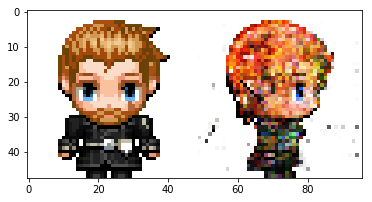

In [34]:
image = plt.imread('Dad.png')
predict_on_image(image[0:48, 48:96, :], cpu_est)

In [0]:
R, C = 4, 4
EXAMPLES = R * C
    
CHANNELS = 4
LATENT_DIM = 128
ADD_NOISE_TO_EXAMPLE = False

DROPOUT_PROB = 0.5
ALPHA = 0.2
BATCH_SIZE = 1024
EPOCHS = 40000
EVAL_EPOCHS = 5000
G_LR = 0.0002
D_LR = 0.0001
KERNEL_SIZE = 4

RUN_NAME = 'Pix2Pix_3'

margonem_data_file = 'gs://tputestingmnist/datasets/characters_margonem_conditional_7.tfrecords'
data_file = 'gs://tputestingmnist/datasets/characters_conditional_7.tfrecords'
MODEL_DIR = 'gs://tputestingmnist/{}/'.format(RUN_NAME)
GOOGLE_DRIVE_DIR = '/content/gdrive/My Drive/Programowanie/PixelGen/{}'.format(RUN_NAME)
TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

# try:
#     do_experiment()
# except Exception as e:
#     print (e)
#     pass